In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Selected the columns that are medically or behaviorally linked to multiple births
# zero-based (start, end) pairs, end is exclusive
colspecs = [
    (74, 76),    # MAGER       Mother’s age in single years (pos 75–76)
    # (78, 79),    # MAGER9      Mother’s age recode 9 (pos 79)
    (83, 84),    # MBSTATE_REC Mother’s nativity recode (pos 84)
    (170,172),   # PRIORLIVE   Prior live births now living (pos 171–172)
    (200,202),   # ILLB_R11    Interval since last live birth recode 11 (pos 201–202)
    (324,325),   # RF_INFTR    Infertility treatment used (pos 325)
    (325,326),   # RF_FEDRG    Fertility enhancing drugs (pos 326)
    (326,327),   # RF_ARTEC    Assisted reproductive tech flag (pos 327)
    (286,287),   # BMI_R       BMI recode (pos 287)
    (305,306),   # WTGAIN_REC  Weight gain recode (pos 306)
    (260,261),   # CIG0_R      Cigarettes before pregnancy recode (pos 261)
    (261,262),   # CIG1_R      Cigarettes 1st trimester recode (pos 262)
    (226,227),   # PRECARE5    Month prenatal care began recode (pos 227)
    (241,243),   # PREVIS_REC  Prenatal visits recode (pos 242–243)
    (250,251),   # WIC         WIC participation flag (pos 251)
    (317,318),   # RF_PPTERM   Prior preterm birth flag (pos 318)
    (312,313),   # RF_PDIAB    Pre-pregnancy diabetes flag (pos 313)
    (314,315),   # RF_PHYPE    Pre-pregnancy hypertension flag (pos 315)
    (453,454),   # DPLURAL     Plurality recode (pos 454) -- target
    (455,456),   # IMP_PLUR    Plurality imputed flag (pos 456)
]

column_names = [
    "mager", "mbstate_rec",
    "priorlive", "illb_r11",
    "rf_inftr", "rf_fedrg", "rf_artec",
    "bmi_r", "wtgain_rec",
    "cig0_r", "cig1_r",
    "precare5", "previs_rec", "wic",
    "rf_ppterm", "rf_pdiab", "rf_phype",
    "dplural", "imp_plur",
]
import pandas as pd

# Load data from fixed-width file
df = pd.read_fwf("data.txt",
                 colspecs=colspecs,
                 names=column_names)

In [5]:
# Data cleaning


# Replace feature-specific "unknown" codes with NaN

df['mbstate_rec'] = df['mbstate_rec'].replace(3, np.nan)

df['priorlive'] = df['priorlive'].replace(99, np.nan)

df['illb_r11'] = df['illb_r11'].replace([88, 99], np.nan)

df['rf_inftr'] = df['rf_inftr'].replace('U', np.nan)

df['rf_fedrg'] = df['rf_fedrg'].replace(['X', 'U'], np.nan)

df['rf_artec'] = df['rf_artec'].replace(['X', 'U'], np.nan)

df['bmi_r'] = df['bmi_r'].replace(9, np.nan)

df['wtgain_rec'] = df['wtgain_rec'].replace(9, np.nan)

df['cig0_r'] = df['cig0_r'].replace(6, np.nan)

df['cig1_r'] = df['cig1_r'].replace(6, np.nan)

df['precare5'] = df['precare5'].replace(5, np.nan)

df['previs_rec'] = df['previs_rec'].replace(12, np.nan)

df['wic'] = df['wic'].replace('U', np.nan)

df['rf_ppterm'] = df['rf_ppterm'].replace('U', np.nan)

df['rf_pdiab'] = df['rf_pdiab'].replace('U', np.nan)

df['rf_phype'] = df['rf_phype'].replace('U', np.nan)

df['imp_plur'] = df['imp_plur'].fillna(0).astype(int)

In [7]:
# Convert Y/N to binary values

yes_no_cols = [
    'rf_inftr', 'rf_fedrg', 'rf_artec', 'wic', 'rf_ppterm', 'rf_pdiab', 'rf_phype'
]

for col in yes_no_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0}).astype('Int64')

In [8]:
# Cast ordinal values to Int64

ordinal_cols = [
    'priorlive', 'illb_r11', 'bmi_r',
    'wtgain_rec', 'cig0_r', 'cig1_r',
    'precare5', 'previs_rec'
]

for col in ordinal_cols:
    df[col] = df[col].astype('Int64')

In [9]:
# Cast mbstate_rec to Int64 as well for aesthetics and consistency purposes

df['mbstate_rec'] = df['mbstate_rec'].astype('Int64')

In [11]:
df.head()

,mager,mbstate_rec,priorlive,illb_r11,rf_inftr,rf_fedrg,rf_artec,bmi_r,wtgain_rec,cig0_r,cig1_r,precare5,previs_rec,wic,rf_ppterm,rf_pdiab,rf_phype,dplural,imp_plur
0,37,1,1,4,0,<NA>,<NA>,2,2,0,0,1,7,0,0,0,0,1,0
1,29,2,1,8,0,<NA>,<NA>,4,3,0,0,1,5,1,0,0,0,1,0
2,22,1,1,3,0,<NA>,<NA>,2,3,0,0,1,6,0,0,0,0,1,0
3,21,1,2,4,0,<NA>,<NA>,4,5,0,0,1,4,0,0,0,0,1,0
4,35,2,0,<NA>,0,<NA>,<NA>,2,3,0,0,1,6,1,0,0,0,1,0


In [15]:
# Renaming columns to a less cryptic name

df.rename(columns={
    'mager': 'mother_age',
    'mbstate_rec': 'mother_nativity',
    'priorlive': 'prior_live_births',
    'illb_r11': 'months_since_last_birth',
    'rf_inftr': 'infertility_treatment',
    'rf_fedrg': 'fertility_drugs',
    'rf_artec': 'assisted_repro_tech',
    'bmi_r': 'bmi_category',
    'wtgain_rec': 'weight_gain_category',
    'cig0_r': 'cigs_before_pregnancy',
    'cig1_r': 'cigs_first_trimester',
    'precare5': 'prenatal_care_start',
    'previs_rec': 'prenatal_visits',
    'wic': 'wic_participation',
    'rf_ppterm': 'prior_preterm_birth',
    'rf_pdiab': 'pre_pregnancy_diabetes',
    'rf_phype': 'pre_pregnancy_hypertension',
    'dplural': 'plurality',
    'imp_plur': 'plurality_imputed'
}, inplace=True)

In [17]:
df.head()

,mother_age,mother_nativity,prior_live_births,months_since_last_birth,infertility_treatment,fertility_drugs,assisted_repro_tech,bmi_category,weight_gain_category,cigs_before_pregnancy,cigs_first_trimester,prenatal_care_start,prenatal_visits,wic_participation,prior_preterm_birth,pre_pregnancy_diabetes,pre_pregnancy_hypertension,plurality,plurality_imputed
0,37,1,1,4,0,<NA>,<NA>,2,2,0,0,1,7,0,0,0,0,1,0
1,29,2,1,8,0,<NA>,<NA>,4,3,0,0,1,5,1,0,0,0,1,0
2,22,1,1,3,0,<NA>,<NA>,2,3,0,0,1,6,0,0,0,0,1,0
3,21,1,2,4,0,<NA>,<NA>,4,5,0,0,1,4,0,0,0,0,1,0
4,35,2,0,<NA>,0,<NA>,<NA>,2,3,0,0,1,6,1,0,0,0,1,0


In [19]:
# Simplifying the target variable

df['multiple_birth'] = df['plurality'].apply(lambda x: 1 if x > 1 else 0)

In [21]:
# Data Visualization to explore patterns and understand relationship with the target variable

# Create reusable function to plot the proportion of multiple vs single births by category

def plot_categorical_vs_target(feature):
    ct = pd.crosstab(df[feature], df['multiple_birth'], normalize='index')
    ct.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
    plt.title(f"{feature} vs Multiple Birth")
    plt.ylabel("Proportion")
    plt.xlabel(feature)
    plt.legend(title='Multiple Birth', labels=['Single', 'Multiple'])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

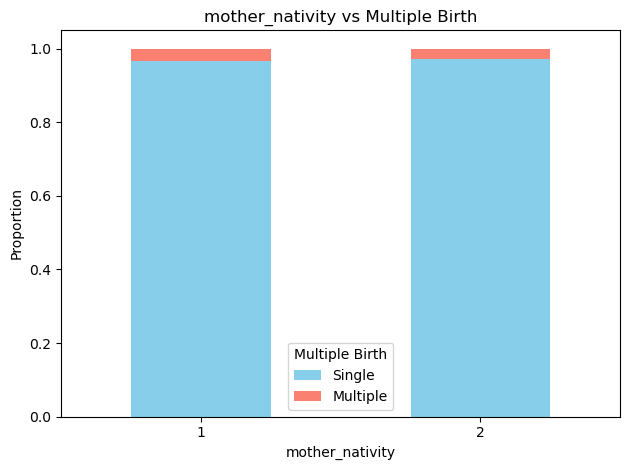

In [23]:
plot_categorical_vs_target('mother_nativity')

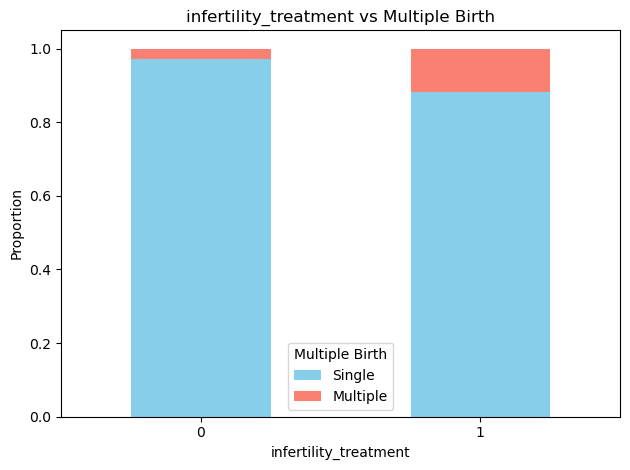

In [25]:
plot_categorical_vs_target('infertility_treatment')

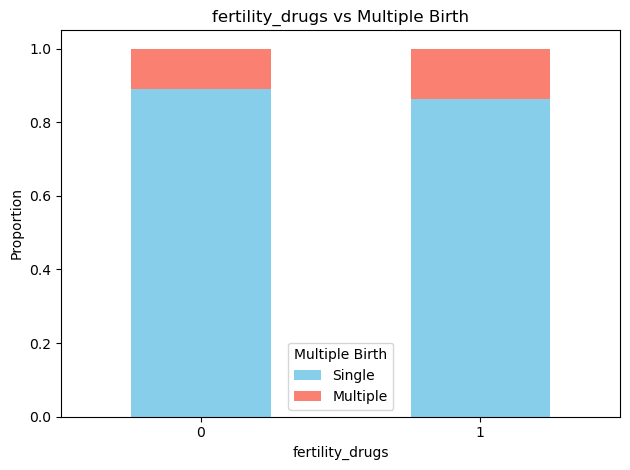

In [27]:
plot_categorical_vs_target('fertility_drugs')

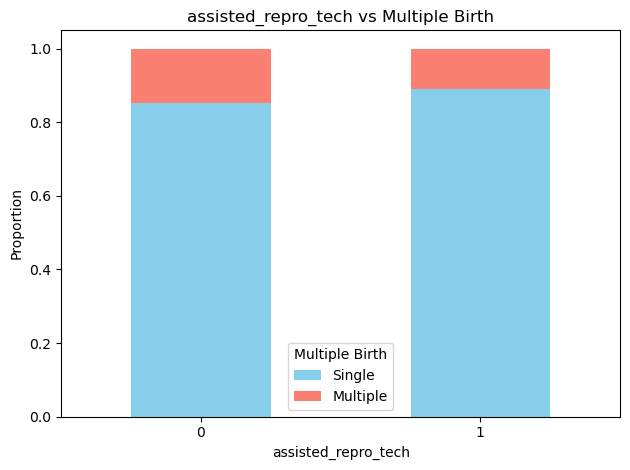

In [29]:
plot_categorical_vs_target('assisted_repro_tech')

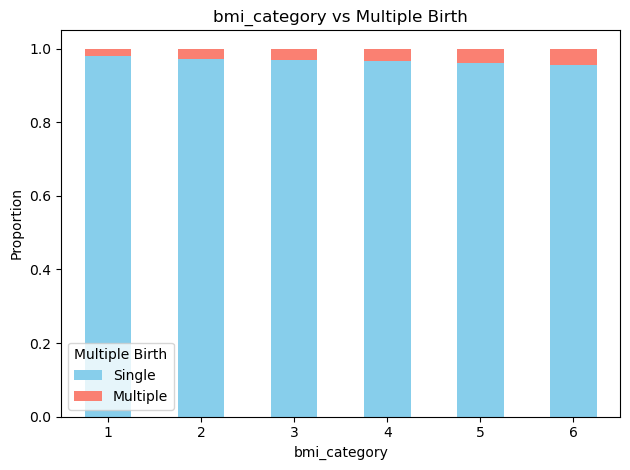

In [31]:
plot_categorical_vs_target('bmi_category')

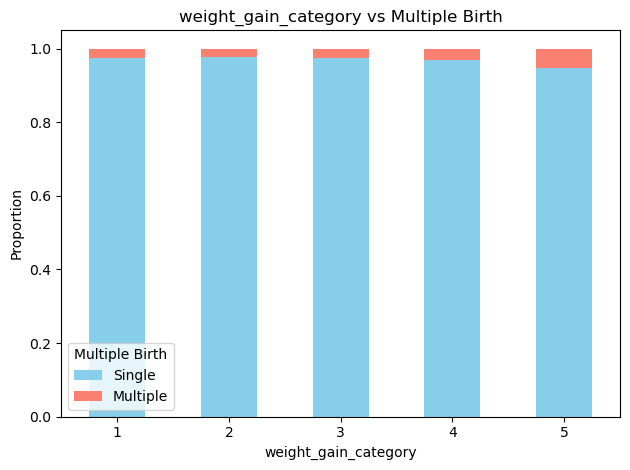

In [33]:
plot_categorical_vs_target('weight_gain_category')

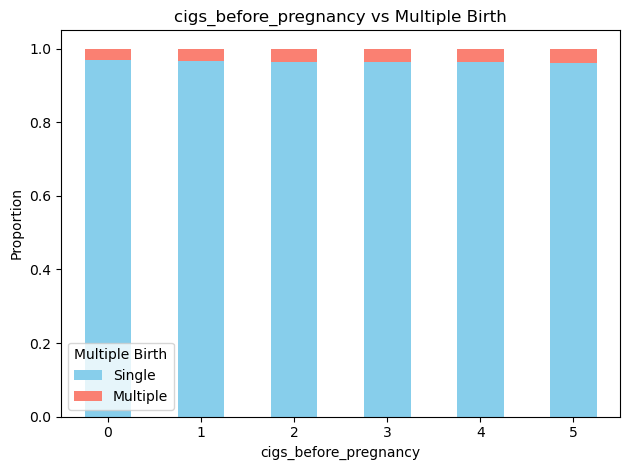

In [35]:
plot_categorical_vs_target('cigs_before_pregnancy')

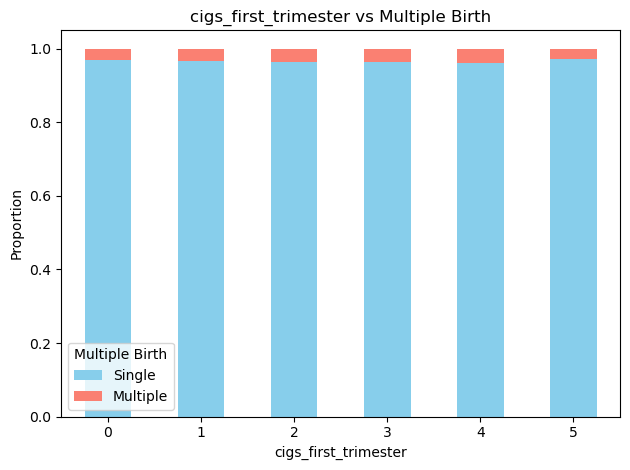

In [37]:
plot_categorical_vs_target('cigs_first_trimester')

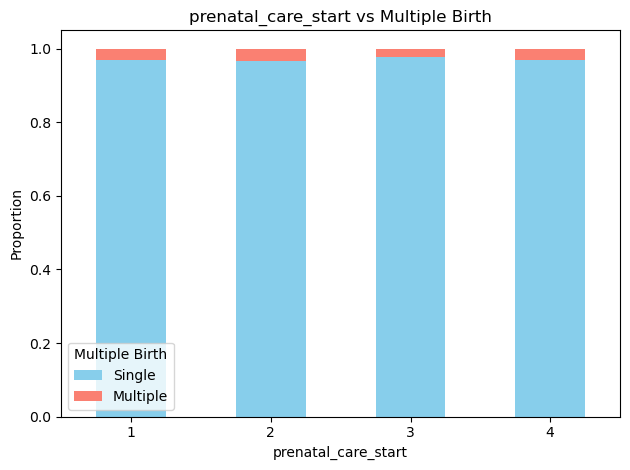

In [39]:
plot_categorical_vs_target('prenatal_care_start')

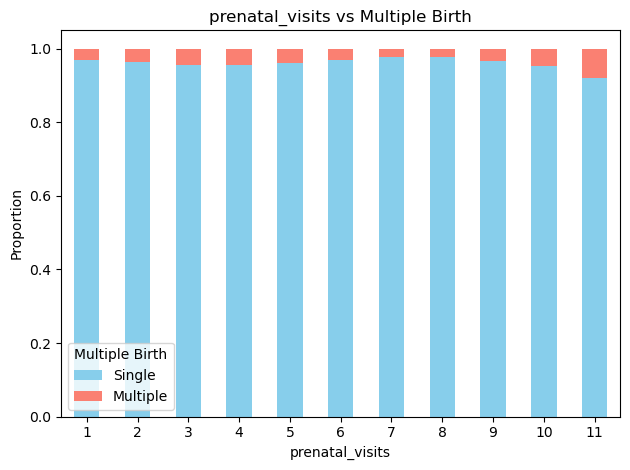

In [41]:
plot_categorical_vs_target('prenatal_visits')

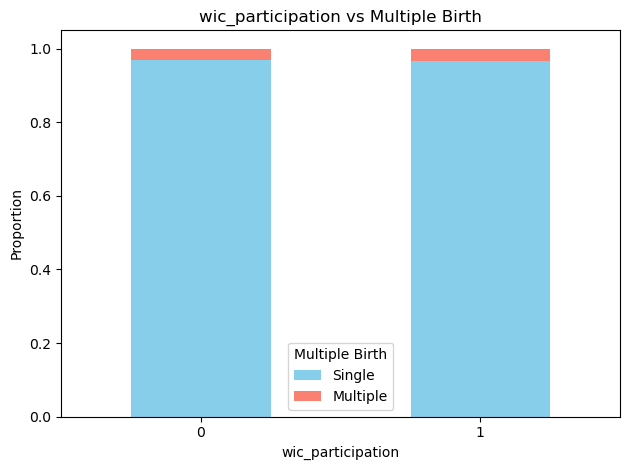

In [43]:
plot_categorical_vs_target('wic_participation')

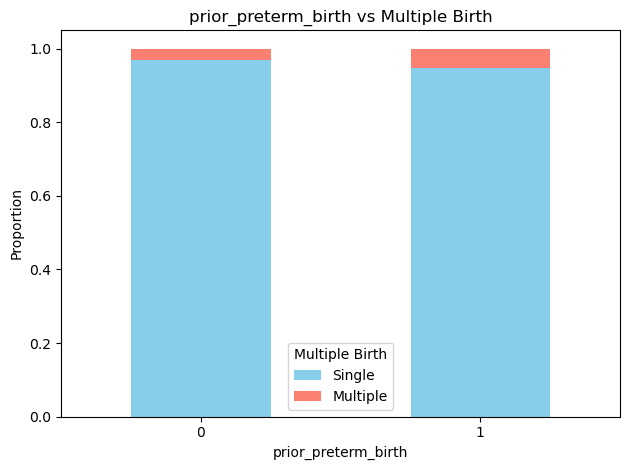

In [45]:
plot_categorical_vs_target('prior_preterm_birth')

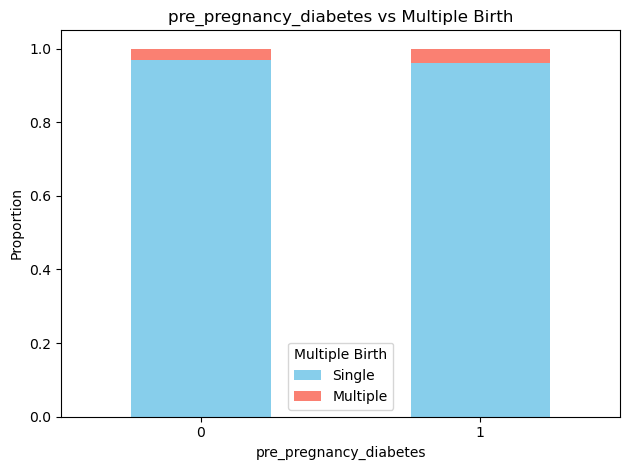

In [47]:
plot_categorical_vs_target('pre_pregnancy_diabetes')

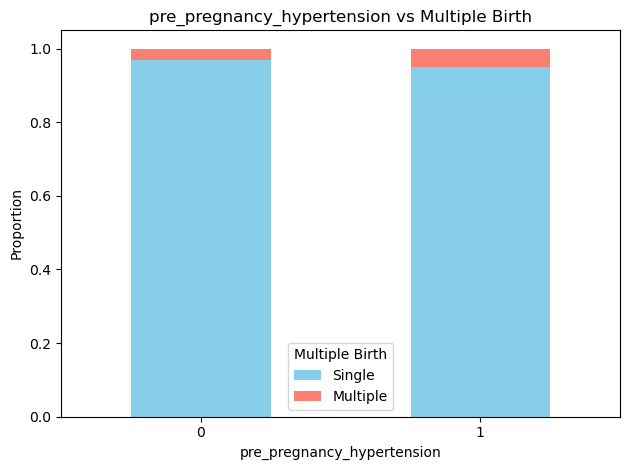

In [49]:
plot_categorical_vs_target('pre_pregnancy_hypertension')

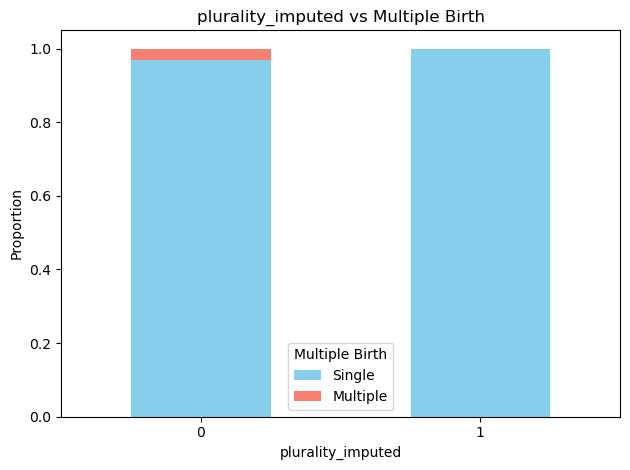

In [51]:
plot_categorical_vs_target('plurality_imputed')

In [53]:
# Create reusable function to plot the proportion of multiple vs single births by numeric variables

def plot_numeric_vs_target(feature):
    sns.boxplot(data=df, x='multiple_birth', y=feature)
    plt.title(f"{feature} by Birth Type")
    plt.xticks([0, 1], ['Single', 'Multiple'])
    plt.xlabel('Birth Type')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

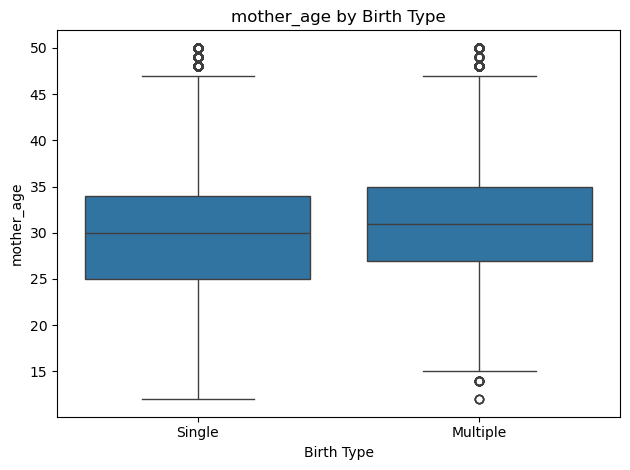

In [55]:
plot_numeric_vs_target('mother_age')

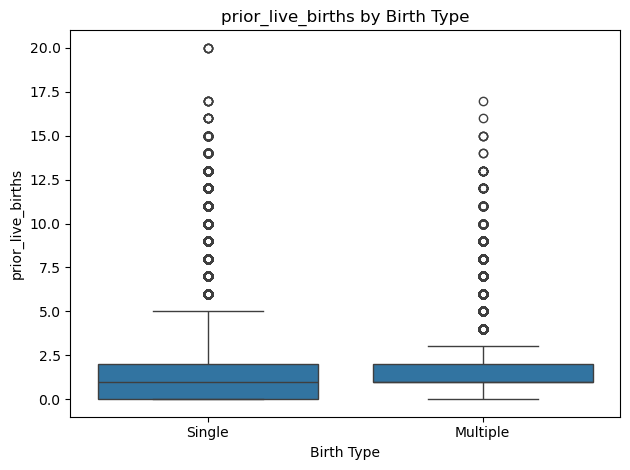

In [56]:
plot_numeric_vs_target('prior_live_births')

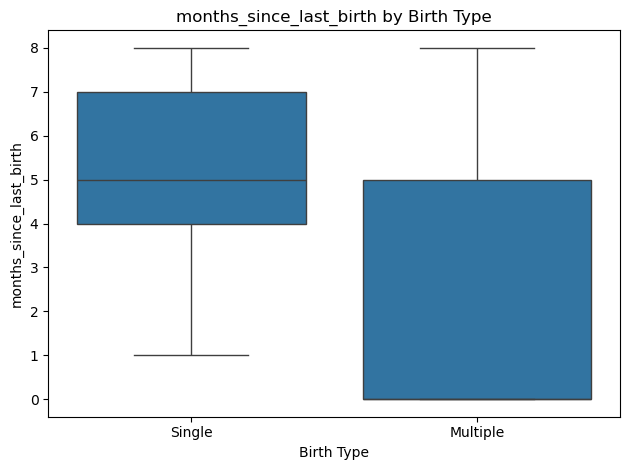

In [57]:
plot_numeric_vs_target('months_since_last_birth')

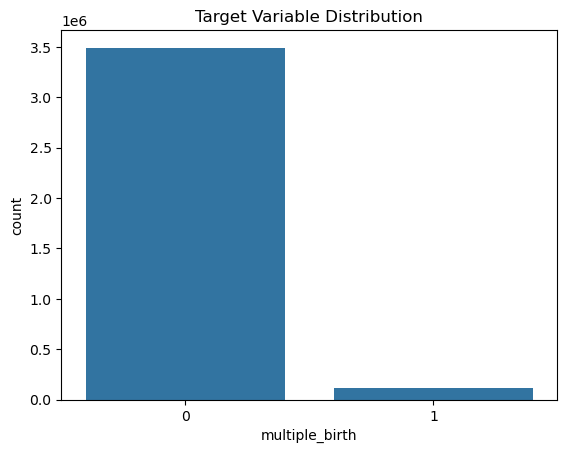

,proportion
multiple_birth,
0,0.968559
1,0.031441


In [60]:
sns.countplot(x=df['multiple_birth'])
plt.title("Target Variable Distribution")
plt.show()

# Numeric breakdown
df['multiple_birth'].value_counts(normalize=True).to_frame(name='proportion')

In [63]:
# Drop duplicates because duplicated values do not add any new information
# Could bias the model by over-representing some cases
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1144063 entries, 0 to 3605079
Data columns (total 20 columns):
 #   Column                      Non-Null Count    Dtype
---  ------                      --------------    -----
 0   mother_age                  1144063 non-null  int64
 1   mother_nativity             1136392 non-null  Int64
 2   prior_live_births           1139999 non-null  Int64
 3   months_since_last_birth     903565 non-null   Int64
 4   infertility_treatment       1139166 non-null  Int64
 5   fertility_drugs             54889 non-null    Int64
 6   assisted_repro_tech         54889 non-null    Int64
 7   bmi_category                1096880 non-null  Int64
 8   weight_gain_category        1082323 non-null  Int64
 9   cigs_before_pregnancy       1131424 non-null  Int64
 10  cigs_first_trimester        1131579 non-null  Int64
 11  prenatal_care_start         1103824 non-null  Int64
 12  prenatal_visits             1106574 non-null  Int64
 13  wic_participation           1112

In [65]:
# dropping unnecessary columns

df.drop(columns=['plurality', 'plurality_imputed'], inplace=True)

In [67]:
# missing values
missing_summary = df.isna().sum().sort_values(ascending=False)
print("Missing Values:")
print(missing_summary)


Missing Values:
fertility_drugs               1089174
assisted_repro_tech           1089174
months_since_last_birth        240498
weight_gain_category            61740
bmi_category                    47183
prenatal_care_start             40239
prenatal_visits                 37489
wic_participation               31904
cigs_before_pregnancy           12639
cigs_first_trimester            12484
mother_nativity                  7671
pre_pregnancy_hypertension       4897
infertility_treatment            4897
prior_preterm_birth              4897
pre_pregnancy_diabetes           4897
prior_live_births                4064
mother_age                          0
multiple_birth                      0
dtype: int64


In [71]:
# Filling in missing values

# Numeric columns: use median since it is more robust to outliers
numeric_features = [
    'mother_age',
    'prior_live_births',
    'months_since_last_birth'
]
for col in numeric_features:
    df[col] = df[col].fillna(df[col].median())

# Categorical columns: use mode
categorical_features = [
    'mother_nativity',
    'infertility_treatment',
    'fertility_drugs',
    'assisted_repro_tech',
    'bmi_category',
    'weight_gain_category',
    'cigs_before_pregnancy',
    'cigs_first_trimester',
    'prenatal_care_start',
    'prenatal_visits',
    'wic_participation',
    'prior_preterm_birth',
    'pre_pregnancy_diabetes',
    'pre_pregnancy_hypertension',
]
for col in categorical_features:
    df[col] = df[col].fillna(df[col].mode()[0])

In [73]:
# missing values
missing_summary = df.isna().sum().sort_values(ascending=False)
print("Missing Values:")
print(missing_summary)

Missing Values:
mother_age                    0
mother_nativity               0
pre_pregnancy_hypertension    0
pre_pregnancy_diabetes        0
prior_preterm_birth           0
wic_participation             0
prenatal_visits               0
prenatal_care_start           0
cigs_first_trimester          0
cigs_before_pregnancy         0
weight_gain_category          0
bmi_category                  0
assisted_repro_tech           0
fertility_drugs               0
infertility_treatment         0
months_since_last_birth       0
prior_live_births             0
multiple_birth                0
dtype: int64


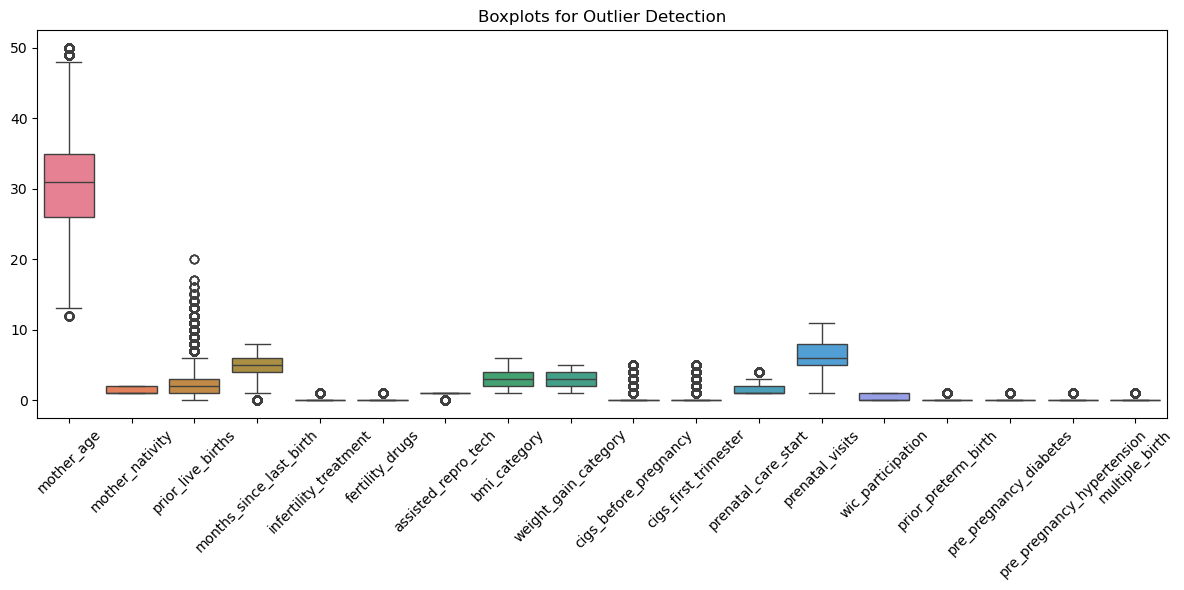

In [75]:
# Analizing outliers
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplots for Outlier Detection")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [76]:
# Cap outliers
# Using winsorization in order to maintain data points
# Instead of removing outliers we are caping them using 1st–99th percentile
def cap_outliers(df, columns):
    for col in columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    return df

numeric_cols = df.select_dtypes(include='number').columns.tolist()
df = cap_outliers(df, numeric_cols)

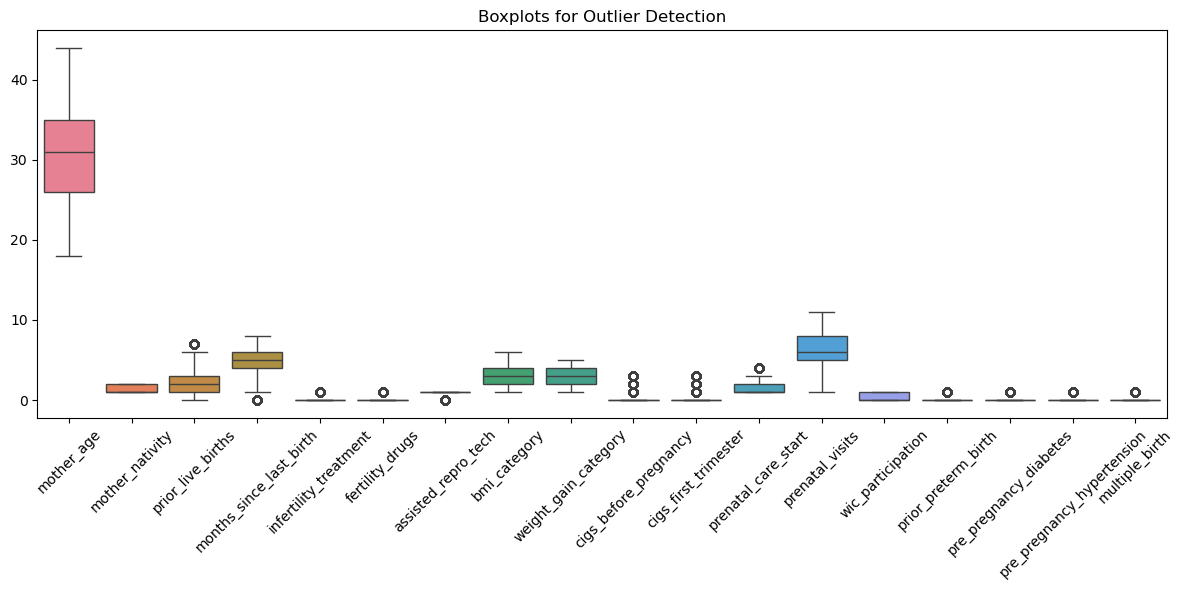

In [77]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplots for Outlier Detection")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [78]:
# encoding

# One-hot encode 'mother_nativity' (3 categories: 1, 2, 3)
df = pd.get_dummies(df, columns=['mother_nativity'], prefix='mother_nativity', drop_first=True)

# Check that all remaining columns are numeric
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()
print("Non-numeric columns remaining:", non_numeric_cols)

Non-numeric columns remaining: ['mother_nativity_2']


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1144063 entries, 0 to 3605079
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype
---  ------                      --------------    -----
 0   mother_age                  1144063 non-null  int64
 1   prior_live_births           1144063 non-null  Int64
 2   months_since_last_birth     1144063 non-null  Int64
 3   infertility_treatment       1144063 non-null  Int64
 4   fertility_drugs             1144063 non-null  Int64
 5   assisted_repro_tech         1144063 non-null  Int64
 6   bmi_category                1144063 non-null  Int64
 7   weight_gain_category        1144063 non-null  Int64
 8   cigs_before_pregnancy       1144063 non-null  Int64
 9   cigs_first_trimester        1144063 non-null  Int64
 10  prenatal_care_start         1144063 non-null  Int64
 11  prenatal_visits             1144063 non-null  Int64
 12  wic_participation           1144063 non-null  Int64
 13  prior_preterm_birth         1144

In [80]:
# casting boolean variable to integer
df['mother_nativity_2'] = df['mother_nativity_2'].astype(int)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1144063 entries, 0 to 3605079
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype
---  ------                      --------------    -----
 0   mother_age                  1144063 non-null  int64
 1   prior_live_births           1144063 non-null  Int64
 2   months_since_last_birth     1144063 non-null  Int64
 3   infertility_treatment       1144063 non-null  Int64
 4   fertility_drugs             1144063 non-null  Int64
 5   assisted_repro_tech         1144063 non-null  Int64
 6   bmi_category                1144063 non-null  Int64
 7   weight_gain_category        1144063 non-null  Int64
 8   cigs_before_pregnancy       1144063 non-null  Int64
 9   cigs_first_trimester        1144063 non-null  Int64
 10  prenatal_care_start         1144063 non-null  Int64
 11  prenatal_visits             1144063 non-null  Int64
 12  wic_participation           1144063 non-null  Int64
 13  prior_preterm_birth         1144

In [89]:
# split data
from sklearn.model_selection import train_test_split

X = df.drop(columns=['multiple_birth'])
y = df['multiple_birth']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [93]:
X_train = X_train.astype('float')  # SMOTE can work better with float

In [95]:
# the target is extremely unbalanced so I applying SMOTE to the training data, risk of not being representative of original dataset

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [97]:
# use a model parameter called class weights. Any classification model has that parameter. 
# threshold tunning - it can be any other than 50% 
# https://scikit-learn.org/stable/modules/classification_threshold.html
# F1 score maximization 


In [99]:
# Use Logistic Regression as a baseline model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_transformed = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_resampled_scaled, y_train_resampled)

y_pred = model.predict(X_test_transformed)

# Evaluation 
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82    212448
           1       0.16      0.68      0.25     16365

    accuracy                           0.71    228813
   macro avg       0.56      0.70      0.54    228813
weighted avg       0.91      0.71      0.78    228813

[[151863  60585]
 [  5164  11201]]


In [ ]:
# Low precision (0.16): Only 16% of predicted multiple births were correct → many false positives
# Recall (68%): It catches over half of the real multiple births


In [ ]:
# Evaluate the importance of the features, some features are detrimental to the model performance
   # Sequential feature selector
   # Permutation importance
# Use a pipeline to train and evaluate the models
# GridSearch 
